In [1]:
import os
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import json

from utils.dlt import *
from utils.files import FileName
from utils.skeleton_keypoints import *
from utils.motion_visualize_tool import *

In [2]:
with open("cube/subsets.json", "r") as f:
    subsets = json.load(f)

imgpoints = []
for i in ["1", "2", "3"]:
    imgpoints.append(subsets[f"{i}.mp4"])
imgpoints = np.array(imgpoints, dtype=np.float32)

In [3]:
with open("cube/3d_points.json", "r") as f:
    points = json.load(f)
cube_3d = np.array(points["object_point"], dtype=np.float32)
objpoints = np.array([cube_3d for _ in range(len(imgpoints))] , dtype=np.float32)

In [4]:
print(f"imgpoints: {imgpoints.shape}")
print(f"objpoints: {objpoints.shape}")

imgpoints: (3, 8, 2)
objpoints: (3, 8, 3)


In [5]:
cam = 3

p1 = prepare_matrix(imgpoints[0], objpoints[0])
p2 = prepare_matrix(imgpoints[1], objpoints[1])
p3 = prepare_matrix(imgpoints[2], objpoints[2])
P = np.array([p1, p2, p3], dtype=np.float32)

cube_array = pose_recon_2c(cam, P, imgpoints)

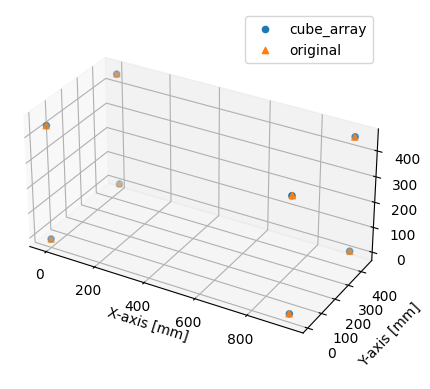

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cube_array[:, 0], cube_array[:, 1], cube_array[:, 2], marker='o', label='cube_array')
ax.scatter(cube_3d[:, 0], cube_3d[:, 1], cube_3d[:, 2], marker='^', label='original')
ax.set_xlabel('X-axis [mm]')
ax.set_ylabel('Y-axis [mm]')
ax.set_zlabel('Z-axis [mm]')
ax.legend()
ax.set_aspect('equal')
plt.show()

In [7]:
data_num = 0

camera_name1 = "1"
camera_name2 = "2"
camera_name3 = "3"

cam1_dir = f"data/hirasaki_{camera_name1}_{data_num}/"
cam2_dir = f"data/hirasaki_{camera_name2}_{data_num}/"
cam3_dir = f"data/hirasaki_{camera_name3}_{data_num}/"

cam1_position = pd.read_csv(os.path.join(cam1_dir, FileName.position_data), index_col="frame")
cam2_position = pd.read_csv(os.path.join(cam2_dir, FileName.position_data), index_col="frame")
cam3_position = pd.read_csv(os.path.join(cam3_dir, FileName.position_data), index_col="frame")

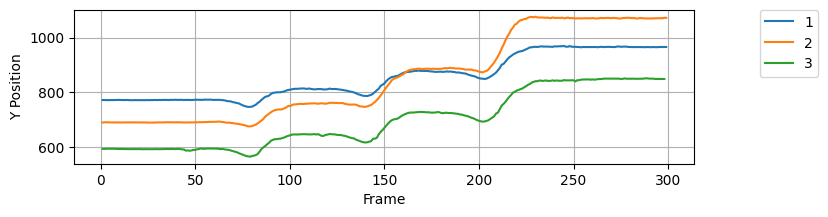

In [8]:
name = "LEFT_ANKLE"

fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(cam1_position.index, cam1_position[f"{name}_y"], label=camera_name1)
ax.plot(cam2_position.index, cam2_position[f"{name}_y"], label=camera_name2)
ax.plot(cam3_position.index, cam3_position[f"{name}_y"], label=camera_name3)
ax.grid()
ax.set_xlabel('Frame')
ax.set_ylabel('Y Position')
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0)
plt.show()

In [9]:
df_camera_sync = pd.read_csv("camera_sync.csv")

toe_off_1 = df_camera_sync["toe_off_1"].iloc[data_num]
toe_off_2 = df_camera_sync["toe_off_2"].iloc[data_num]
toe_off_3 = df_camera_sync["toe_off_3"].iloc[data_num]

delay_1 = toe_off_1 - toe_off_1
delay_2 = toe_off_2 - toe_off_1
delay_3 = toe_off_3 - toe_off_1

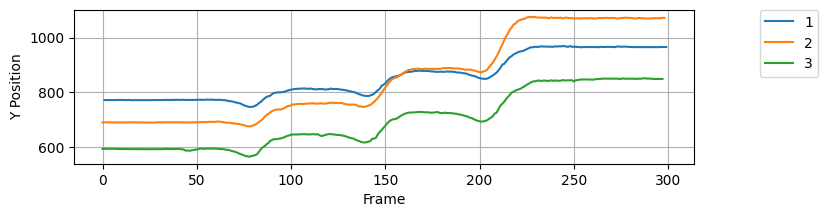

In [10]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(cam1_position.index - delay_1, cam1_position[f"{name}_y"], label=camera_name1)
ax.plot(cam2_position.index - delay_2, cam2_position[f"{name}_y"], label=camera_name2)
ax.plot(cam3_position.index - delay_3, cam3_position[f"{name}_y"], label=camera_name3)
ax.grid()
ax.set_xlabel('Frame')
ax.set_ylabel('Y Position')
ax.legend(bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0)
plt.show()

In [11]:
cam1_position["ID"] = cam1_position.index - delay_1
cam2_position["ID"] = cam2_position.index - delay_2
cam3_position["ID"] = cam3_position.index - delay_3

In [12]:
cam1_position = cam1_position.loc[cam1_position["ID"] > 0]
cam2_position = cam2_position.loc[cam2_position["ID"] > 0]
cam3_position = cam3_position.loc[cam3_position["ID"] > 0]

In [13]:
cam1_position.set_index("ID", inplace=True, drop=True)
cam2_position.set_index("ID", inplace=True, drop=True)
cam3_position.set_index("ID", inplace=True, drop=True)

In [14]:
min_frame = max(cam1_position.index.min(), cam2_position.index.min(), cam3_position.index.min())
max_frame = min(cam1_position.index.max(), cam2_position.index.max(), cam3_position.index.max())
print(min_frame, max_frame)

1.0 297.0


In [15]:
frame = min_frame
cam1_pose = cam1_position.loc[frame].values.reshape(-1, 2)
cam2_pose = cam2_position.loc[frame].values.reshape(-1, 2)
cam3_pose = cam3_position.loc[frame].values.reshape(-1, 2)
pose = np.array([cam1_pose, cam2_pose, cam3_pose], dtype=np.float32)
pose_result = pose_recon_2c(cam, P, pose)

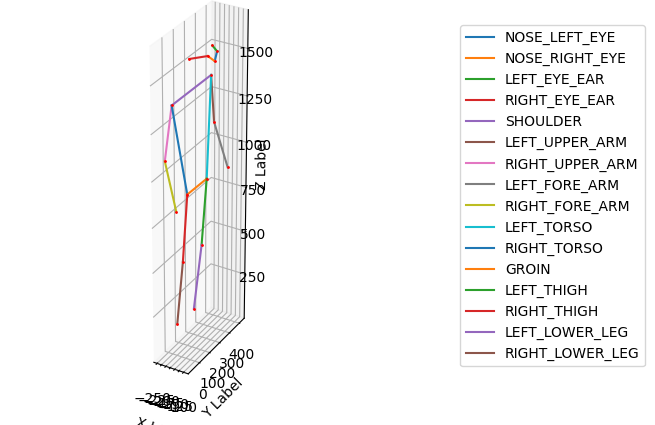

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for key, value in exp_keypoints_connections.items():
    start_idx = value[0]
    end_idx = value[1]
    ax.plot([pose_result[start_idx][0], pose_result[end_idx][0]],
            [pose_result[start_idx][1], pose_result[end_idx][1]],
            [pose_result[start_idx][2], pose_result[end_idx][2]], label=key)
for i in range(len(pose_result)):
    ax.scatter(pose_result[i][0], pose_result[i][1], pose_result[i][2], color='r', s=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
ax.set_aspect('equal')
plt.show()

In [17]:
columns = [f"{kpt}_{xyz}" for kpt in exp_keypoints_list for xyz in ["x", "y", "z"]]
position_df = pd.DataFrame(columns=columns)
position_df.index.name = 'frame'

for frame in range(int(min_frame), int(max_frame) + 1):
    cam1_pose = cam1_position.loc[frame].values.reshape(-1, 2)
    cam2_pose = cam2_position.loc[frame].values.reshape(-1, 2)
    cam3_pose = cam3_position.loc[frame].values.reshape(-1, 2)
    pose = np.array([cam1_pose, cam2_pose, cam3_pose], dtype=np.float32)
    pose_result = pose_recon_2c(cam, P, pose)
    position_df.loc[frame] = pose_result.ravel()

position_df

,NOSE_x,NOSE_y,NOSE_z,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_z,RIGHT_EYE_x,RIGHT_EYE_y,RIGHT_EYE_z,LEFT_EAR_x,...,LEFT_KNEE_z,RIGHT_KNEE_x,RIGHT_KNEE_y,RIGHT_KNEE_z,LEFT_ANKLE_x,LEFT_ANKLE_y,LEFT_ANKLE_z,RIGHT_ANKLE_x,RIGHT_ANKLE_y,RIGHT_ANKLE_z
frame,,,,,,,,,,,,,,,,,,,,,
1,-86.283722,161.505837,1555.072051,-92.974481,194.793740,1589.498755,-106.444338,132.172150,1588.385631,-154.737031,...,472.704630,-216.238273,87.117172,476.887209,-253.824819,256.260732,96.951880,-256.150990,96.992403,95.819972
2,-87.512331,163.535427,1554.665334,-94.186580,196.818234,1589.089820,-107.513148,132.989466,1589.072817,-153.400280,...,473.540016,-217.436799,88.045287,476.576590,-252.821726,255.972445,95.843705,-257.250924,97.781190,96.521192
3,-87.132189,163.932552,1553.597877,-93.772789,197.207484,1588.014050,-107.160942,134.555457,1588.866601,-152.988549,...,476.665349,-214.628673,87.408610,479.044454,-252.129246,256.253844,96.140323,-256.696932,98.092306,96.799146
4,-86.344377,167.215559,1554.680058,-93.390575,197.236496,1588.057788,-108.920931,135.590289,1588.943284,-152.554568,...,477.640738,-214.061778,87.338013,479.855197,-251.856002,256.401079,96.833278,-256.302367,98.010374,96.386339
5,-86.576446,167.648025,1554.491759,-93.496006,197.600456,1588.949290,-109.150789,136.027553,1588.754485,-152.678388,...,476.103744,-214.447803,87.691897,479.459670,-252.150522,256.867944,96.625419,-256.467301,98.471581,95.254311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,4025.471725,51.847238,1528.924862,3952.887823,51.004583,1563.877980,4061.934662,47.220533,1553.382239,3979.682494,...,435.714611,3954.867668,-7.048715,432.004332,3888.511223,212.351096,74.312438,3904.093462,8.767712,82.164762
294,4024.792278,50.600778,1528.577249,3953.536580,50.380558,1564.417309,4062.464751,46.785844,1552.149299,3980.240337,...,433.243690,3955.207792,-4.673471,429.765422,3889.021424,212.162974,74.411252,3904.653755,10.677459,83.300229
295,4025.793859,50.115155,1529.610922,3953.145260,50.534648,1565.656754,4063.375509,47.770243,1554.088478,3979.757405,...,432.892161,3954.790257,-4.142214,429.683727,3888.567165,212.715589,74.195227,3905.563781,9.858036,82.452907


In [18]:
plot_3d_motion_exp(position_df/1000, output_name="camera1-3.html")